In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import glob
import shutil
from skimage import io
import cv2
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import random
from torchvision.transforms import Compose, ColorJitter, RandomRotation
import seaborn as sns  

In [2]:
#to są funkcje których będę używał w programie, uznałem że warto je zgromadzić w jednym miejsu
#ta znajduje dostępne klasy, ich nazwy oraz ilość plików w nich
def Classes_and_velocity(path):
    classes =[]
    for dirname, _, filenames in os.walk(path):
        classname = dirname.replace(path, '')
        number = 0
        for filename in filenames:
            number = number+ 1
        classes.append((classname[1:],number))
    
    classes.pop(0)

    return classes

def create_new_folder(parent_dir,new_folder_name):
        path = os.path.join(parent_dir, new_folder_name)
        os.mkdir(path)

def path_create(read_path,classname,save_path,filename):
        final_readpath = os.path.join(read_path, classname,filename)
        final_savepath = os.path.join(save_path, classname)
        return final_readpath,final_savepath

#kopuje pliki z jednego miejsca do 2
def copy_relocating_image(readpath,save_path):
    for jpgfile in glob.iglob(readpath):
        shutil.copy(jpgfile, save_path)

#znajduje pliki, na stałe dzieli dane w oddzielnych folderach oraz zwraca podzbiory danych do modelu
def Image_DS_Split(loadpath,savepath,train_to_val_ratio = 0.8,trainval_to_test_ratio = 0.8,batchsize = 32,img_height =180,img_width = 180):
    DataTable =[]
    classes = Classes_and_velocity(loadpath)
    for dirname, _, filenames in os.walk(loadpath):
        classname = dirname.replace(loadpath, '')
        filenamestable = []
        for filename in filenames:
            filenamestable.append((classname[1:],filename))
        DataTable.append(filenamestable)
    DataTable.pop(0)
    import random
    Train_val_img_names = []
    for idex,filenames in enumerate(DataTable): 
        l = classes[idex][1] 
        number_of_files = int(l*trainval_to_test_ratio)
        Train_val_img_names.append(random.sample(filenames, number_of_files))

    
    for index in range (len(DataTable)):
        for element in Train_val_img_names[index]:
            DataTable[index].remove(element)

    
    DataTable = np.array(DataTable,dtype = object)
    DataTable = DataTable.flatten()
    
    Train_val_img_names = np.array(Train_val_img_names, dtype = object)
    Train_val_img_names = Train_val_img_names.flatten()
    
    create_new_folder(savepath,new_folder_name= 'train_val')
    create_new_folder(savepath,new_folder_name= 'test')
    sp1 = os.path.join(savepath, 'train_val')
    sp2 = os.path.join(savepath,'test')

    for i, dat in enumerate(classes):
        create_new_folder(sp1,dat[0])
        create_new_folder(sp2,dat[0])
    

    for j in range(len (DataTable)):
        for i, data in enumerate(DataTable[j]):
            x,y = path_create(loadpath,data[0],sp2,data[1])
            copy_relocating_image(x,y)
    
    for j in range(len (Train_val_img_names)):
        for i, data in enumerate(Train_val_img_names[j]):
            x,y = path_create(loadpath,data[0],sp1,data[1])
            copy_relocating_image(x,y)  

    test_ds = tf.keras.utils.image_dataset_from_directory( sp2, validation_split= 0.999999, subset="validation", seed=123, image_size=(img_height, img_width),
    batch_size=batchsize)
    train_ds = tf.keras.utils.image_dataset_from_directory( sp1, validation_split= (1 -train_to_val_ratio), subset="training", seed=123, image_size=(img_height, img_width),
    batch_size=batchsize)
    val_ds = tf.keras.utils.image_dataset_from_directory( sp1, validation_split= (1 -train_to_val_ratio), subset="validation", seed=123, image_size=(img_height, img_width),
    batch_size=batchsize)
    

    return train_ds , val_ds,test_ds,classes

#tworzy nowe zdj na podstawie istniejących, balansuje klasy. robi backup
def T_function(loadpath,classes,savepath, data_transforms_table,number_of_additional_tranforemd_img =0):
    maxvfiles = max(classes,key =lambda x:x[1])[1]
    needed_files_in_classes = []

    for index,data in enumerate(classes):
        needed_files_in_classes.append((data[0], maxvfiles- data[1])) 

    DataTable =[]
    for dirname, _, filenames in os.walk(loadpath):
        classname = dirname.replace(loadpath, '')
        filenamestable = []
        for filename in filenames:
            filenamestable.append((classname[1:],filename))
        DataTable.append(filenamestable)

    DataTable.pop(0)

    Files_to_transform = []
    for idex,filenames in enumerate(DataTable):
        number_of_files = needed_files_in_classes[idex][1]
        Files_to_transform.append(random.sample(filenames, number_of_additional_tranforemd_img+ number_of_files))

    for i, dat in enumerate(classes):
        create_new_folder(savepath,dat[0])

    for j in range(len (DataTable)):
        for i, data in enumerate(DataTable[j]):
            x,y = path_create(loadpath,data[0],savepath,data[1])
            copy_relocating_image(x,y)


    just_names_table = []
    for j in range(len(Files_to_transform)):
        for i,d in enumerate(Files_to_transform[j]):
            just_names_table.append(d[1])

    for dirname, _, filenames in os.walk(loadpath):
        for filename in filenames:
            cl= dirname.replace(loadpath, '')
            if filename in just_names_table:
                fp = os.path.join(dirname,filename)
                img = Image.open(fp)
                img.load()
                img = random.choice(data_transforms_table)(img)
                img_name = '_t_'+ filename
                img_name.replace('.jpg','')
                x,y =path_create(loadpath,cl[1:],savepath,img_name)
                img.save(x,'JPEG')

def evaluate_conf_matrix(test_path,img_size,model,class_names):
    pred = []
    true = []
    for dirname, _, filenames in os.walk(test_path):
        for filename in filenames:
            path = os.path.join(dirname,filename)

            img = tf.keras.utils.load_img(path, target_size=img_size )

            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)
            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            classname = dirname.replace(test_path, '')
            classname = classname[1:]

            pred.append( class_names.index(class_names[np.argmax(score)]))
            true.append(class_names.index(classname))
    return tf.math.confusion_matrix(true,pred)
                

In [3]:
classes = Classes_and_velocity(r'Data\flowers')

In [4]:
names = []
numbers = []
for i,c in enumerate(classes):
    names.append(c[0] +': ' +str(c[1]) )
    numbers.append(c[1])


df =pd.DataFrame(numbers,index =names, columns= pd.Index(['flowers']))

<AxesSubplot:>

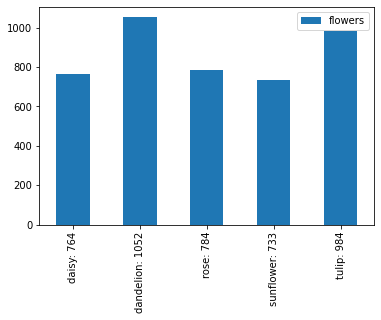

In [5]:
df.plot.bar()

In [6]:
train_ds, val_ds,test_ds,classes = Image_DS_Split(r'Data\flowers',r'Data',0.8,0.7,batchsize=32,img_height=180, img_width = 180)

Found 1298 files belonging to 5 classes.
Using 1297 files for validation.
Found 3019 files belonging to 5 classes.
Using 2416 files for training.
Found 3019 files belonging to 5 classes.
Using 603 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len (class_names)

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


In [9]:
model1 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(5, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(10, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(50, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])




In [10]:
epochs = 13
history = model1.fit(
  train_ds,
  validation_data= val_ds,
  epochs=epochs
)


Epoch 1/13


C:\Users\macie\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


76/76 [==============================] - 22s 266ms/step - loss: 1.4131 - accuracy: 0.3783 - val_loss: 1.2294 - val_accuracy: 0.4726
Epoch 2/13
76/76 [==============================] - 21s 274ms/step - loss: 1.1547 - accuracy: 0.5315 - val_loss: 1.1144 - val_accuracy: 0.5423
Epoch 3/13
76/76 [==============================] - 21s 273ms/step - loss: 1.0626 - accuracy: 0.5857 - val_loss: 1.0726 - val_accuracy: 0.5556
Epoch 4/13
76/76 [==============================] - 21s 273ms/step - loss: 0.9836 - accuracy: 0.6138 - val_loss: 1.0075 - val_accuracy: 0.5970
Epoch 5/13
76/76 [==============================] - 21s 274ms/step - loss: 0.9349 - accuracy: 0.6436 - val_loss: 1.0293 - val_accuracy: 0.5705
Epoch 6/13
76/76 [==============================] - 21s 275ms/step - loss: 0.8901 - accuracy: 0.6556 - val_loss: 1.0436 - val_accuracy: 0.5854
Epoch 7/13
76/76 [==============================] - 21s 273ms/step - loss: 0.8566 - accuracy: 0.6842 - val_loss: 0.9432 - val_accuracy: 0.6318
Epoch 8/13

In [11]:
test_loss, test_acc = model1.evaluate(test_ds,verbose=2)
print(f'\nTest accuracy: {round(100 * test_acc, 2)}')

41/41 - 2s - loss: 0.8816 - accuracy: 0.6793 - 2s/epoch - 61ms/step

Test accuracy: 67.93


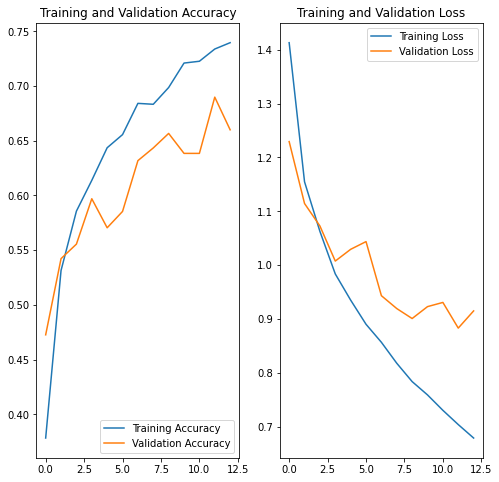

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model1.compile(optimizer= Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs = 3
history2 = model1.fit(
  train_ds,
  validation_data= val_ds,
  epochs=epochs
)

Epoch 1/3
76/76 [==============================] - 21s 272ms/step - loss: 0.5908 - accuracy: 0.7777 - val_loss: 0.8626 - val_accuracy: 0.6998
Epoch 2/3
76/76 [==============================] - 21s 273ms/step - loss: 0.5891 - accuracy: 0.7885 - val_loss: 0.8547 - val_accuracy: 0.7015
Epoch 3/3
76/76 [==============================] - 21s 276ms/step - loss: 0.5618 - accuracy: 0.7976 - val_loss: 0.8573 - val_accuracy: 0.7048


In [15]:
test_loss, test_acc = model1.evaluate(test_ds,verbose=2)
print(f'\nTest accuracy: {round(100 * test_acc, 2)}')

41/41 - 3s - loss: 0.8230 - accuracy: 0.6962 - 3s/epoch - 61ms/step

Test accuracy: 69.62


<AxesSubplot:>

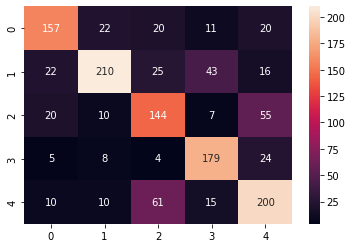

In [16]:
conf_matrix1 =evaluate_conf_matrix(r'Data\test',(180,180),model1,class_names)
sns.heatmap(conf_matrix1, annot=True,fmt="d")

In [17]:
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomInvert, RandomPosterize, RandomPerspective

In [22]:
img_tranform1 = Compose([
    
    ColorJitter(brightness=.5, hue=.3),
])
img_tranform2 = Compose([
    RandomHorizontalFlip(p=0.6),
    RandomVerticalFlip(p=0.6),
    RandomPerspective(p=0.3)
])

img_tranform3 = Compose([
    RandomInvert(p=0.6),
    RandomPosterize(bits =2, p=0.6)
])


In [23]:
img_t_table = [img_tranform1,img_tranform2,img_tranform3]

In [24]:
new_classes= Classes_and_velocity(r'Data\train_val')

In [25]:
T_function(r'Data\train_val',new_classes,r'Data\flowersv2',img_t_table,250)

In [26]:
classes2 = Classes_and_velocity(r'Data\train_val')
names = []
numbers = []
for i,c in enumerate(classes2):
    names.append(c[0] +': ' +str(c[1]) )
    numbers.append(c[1])


df2 =pd.DataFrame(numbers,index =names, columns= pd.Index(['flowers']))

<AxesSubplot:>

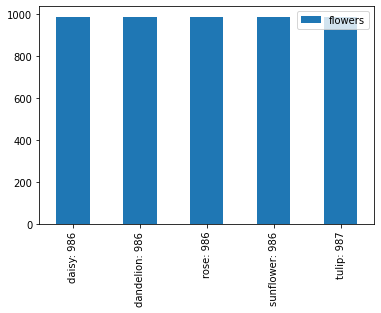

In [27]:
df2.plot.bar()

In [28]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(5, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(10, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(50, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
train2_ds = tf.keras.utils.image_dataset_from_directory( r'Data\train_val', validation_split= 0.2, subset="training", seed=123, image_size=(180, 180),batch_size=32)

val2_ds = tf.keras.utils.image_dataset_from_directory( r'Data\train_val', validation_split= 0.2, subset="validation", seed=123, image_size=(180, 180),batch_size=180)

Found 4931 files belonging to 5 classes.
Using 3945 files for training.
Found 4931 files belonging to 5 classes.
Using 986 files for validation.


In [30]:
epochs = 15
history2 = model2.fit(
  train2_ds,
  validation_data= val2_ds,
  epochs=epochs
)

Epoch 1/15


C:\Users\macie\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


124/124 [==============================] - 34s 267ms/step - loss: 1.5062 - accuracy: 0.3288 - val_loss: 1.3491 - val_accuracy: 0.4341
Epoch 2/15
124/124 [==============================] - 35s 281ms/step - loss: 1.2759 - accuracy: 0.4862 - val_loss: 1.1559 - val_accuracy: 0.5365
Epoch 3/15
124/124 [==============================] - 37s 297ms/step - loss: 1.1451 - accuracy: 0.5523 - val_loss: 1.0783 - val_accuracy: 0.5588
Epoch 4/15
124/124 [==============================] - 33s 265ms/step - loss: 1.0820 - accuracy: 0.5797 - val_loss: 1.1348 - val_accuracy: 0.5558
Epoch 5/15
124/124 [==============================] - 33s 269ms/step - loss: 1.0318 - accuracy: 0.6013 - val_loss: 0.9754 - val_accuracy: 0.6075
Epoch 6/15
124/124 [==============================] - 33s 265ms/step - loss: 1.0088 - accuracy: 0.6086 - val_loss: 0.9431 - val_accuracy: 0.6136
Epoch 7/15
124/124 [==============================] - 33s 265ms/step - loss: 0.9581 - accuracy: 0.6388 - val_loss: 0.9766 - val_accuracy: 0.6

In [31]:
test_loss, test_acc = model2.evaluate(test_ds,verbose=2)
print(f'\nTest accuracy: {round(100 * test_acc, 2)}')

41/41 - 3s - loss: 0.8883 - accuracy: 0.6870 - 3s/epoch - 64ms/step

Test accuracy: 68.7


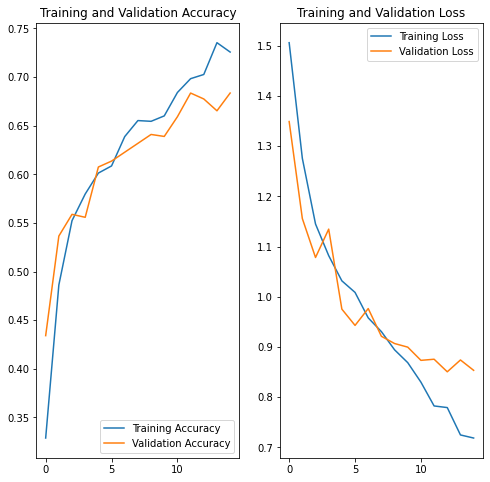

In [32]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
model2.compile(optimizer= Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
epochs = 4
history2 = model2.fit(
  train2_ds,
  validation_data= val2_ds,
  epochs=epochs
)

Epoch 1/4
124/124 [==============================] - 34s 271ms/step - loss: 0.6383 - accuracy: 0.7610 - val_loss: 0.8026 - val_accuracy: 0.7059
Epoch 2/4
124/124 [==============================] - 34s 274ms/step - loss: 0.5946 - accuracy: 0.7792 - val_loss: 0.7964 - val_accuracy: 0.7049
Epoch 3/4
124/124 [==============================] - 34s 271ms/step - loss: 0.5949 - accuracy: 0.7747 - val_loss: 0.7939 - val_accuracy: 0.7069
Epoch 4/4
124/124 [==============================] - 34s 270ms/step - loss: 0.5913 - accuracy: 0.7828 - val_loss: 0.7844 - val_accuracy: 0.7120


In [35]:
test_loss, test_acc = model2.evaluate(test_ds,verbose=2)
print(f'\nTest accuracy: {round(100 * test_acc, 2)}')

41/41 - 3s - loss: 0.8256 - accuracy: 0.6985 - 3s/epoch - 64ms/step

Test accuracy: 69.85


In [65]:
epochs = 2
history2 = model2.fit(
  train2_ds,
  validation_data= val2_ds,
  epochs=epochs)

Epoch 1/2
105/105 [==============================] - 30s 286ms/step - loss: 0.4535 - accuracy: 0.8332 - val_loss: 0.7936 - val_accuracy: 0.7344
Epoch 2/2
105/105 [==============================] - 30s 289ms/step - loss: 0.4371 - accuracy: 0.8350 - val_loss: 0.7952 - val_accuracy: 0.7368


In [66]:
test_loss, test_acc = model2.evaluate(test_ds,verbose=2)
print(f'\nTest accuracy: {round(100 * test_acc, 2)}')

41/41 - 3s - loss: 0.9258 - accuracy: 0.6978 - 3s/epoch - 65ms/step

Test accuracy: 69.78


In [36]:
conf_matrix =evaluate_conf_matrix(r'Data\test',(180,180),model2,class_names)

<AxesSubplot:>

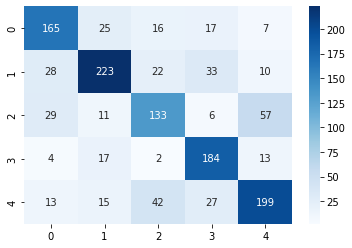

In [37]:
sns.heatmap(conf_matrix, annot=True,fmt="d",cmap='Blues')

Wnioski: z racji tego że w pierwszym modelu użyłem agumentacji, która miała podobny efekt co stworzenie większego zbioru danych, ważne jest to że zbiór został zbalansowany i za złe przewidywania z różnych klas był "karany" w takim samym stopniu więc nie poświęcał dokładności w jednych klasach za dokładnośc w innych. 